### See the related Mathematica notebook "Dephasing.nb" for the derivations of expressions used here

In [3]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed

In [4]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

In [5]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx])/f_new
    return (resampled, t_out)

Specific arguments

In [6]:
f0 = 20
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
pad_len = int(340*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 5*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [7]:
beta

2.308357543241762e-09

## Exact dephasing

In [8]:
def tMax_calc(f0, beta, f_max):
    temp0 = 0.375/beta
    temp1 = 1-(f0/f_max)**(8/3)
    return temp0*temp1

def btMax_calc(f0, fMax):
    return 3/8*(1-(f0/fMax)**(8/3))

def thresh_calc(f0, fMax, thresh=pi/4):
    bt = btMax_calc(f0, fMax)
    temp0 = 5*thresh/(6*pi*f0)
    temp1 = (-1+bt)/(1-8/3*bt)**(3/8)+1
    return -temp0*temp1**(-1)

def thresh_calc1(f0, fMax, phi_thresh=pi/4):
    temp0 = f0/fMax
    temp1 = 5*phi_thresh/(6*pi*f0)
    temp2 = ((-5/8-3/8*temp0**(8/3))/temp0)+1
    return -temp1*temp2**(-1)

In [9]:
np.isclose(thresh_calc(f0, f_max),thresh_calc1(f0, f_max))

True

In [10]:
tMax = max(tMax_calc(f0, beta, 200), 5e7)
beta_thresh = abs(thresh_calc(f0, f_max))

In [11]:
delta_beta = -beta_thresh*beta**2

phi_exact = -6*pi/5*f0*(1-8./3.*(beta)*tMax)**(5/8)/beta
phi_exact0 = -6*pi/5*f0*(1-8./3.*(beta)*0)**(5/8)/beta
phi_offset = -6*pi/5*f0*(1-8./3.*(beta+delta_beta)*tMax)**(5/8)/(beta+delta_beta)
phi_offset0 = -6*pi/5*f0*(1-8./3.*(beta+delta_beta)*0)**(5/8)/(beta+delta_beta)
dephasing = (phi_offset-phi_offset0) - (phi_exact-phi_exact0)

In [12]:
np.isclose(np.abs(dephasing), pi/4, rtol=1e-4)

True

## Comparing to approx_dephasing

In [13]:
def approx_dephasing(t, f0, beta, delta_beta):
    temp0 = 6*f0*pi*(-1+beta*t)*delta_beta
    temp1 = 5*(beta**2*np.power(1-8/3*t*beta, 3/8))
    return -temp0 / temp1

In [14]:
approx = approx_dephasing(tMax, f0, beta, delta_beta) - \
         approx_dephasing(0, f0, beta, delta_beta)
np.isclose(dephasing, approx, rtol=1e-4)

True

## Grid size

In [15]:
def integrated(thresh, step, x0):
    return x0/(x0*thresh*step+1)

def integrated1(thresh, step, x0):
    return 1/(thresh*step+1/x0)

In [16]:
beta0 = np.longdouble(1e-2)
beta_thresh = thresh_calc(f0, f_max)

In [17]:
np.isclose(integrated(beta_thresh, 1e6, beta0),
           integrated1(beta_thresh, 1e6, beta0))

True

0.00048052011378249134407

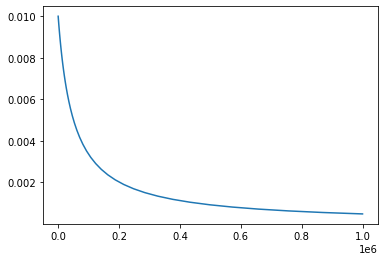

In [24]:
steps = np.logspace(0,6,100) 
pl.plot(steps,integrated(beta_thresh, steps, beta0))
last_beta = integrated(beta_thresh, steps[-1],beta0)
last_beta

In [20]:
# A million steps is a lower limit of the number of steps needed
# between beta(0) and beta(steps[-1])
# Here that is: 5e-4, 1e-2

In [25]:
delta_beta = beta_thresh*last_beta**2
beta_dist = beta0 - last_beta

In [26]:
beta_dist / delta_beta

20810783.384868933355

In [27]:
# An upper limit of the number of steps needed is 20 million 

## Computing the grid points

In [ ]:
# beta=1e-4
# f0=20
# count = 0

# while beta<1e-6:
#     beta_thresh = thresh_calc(f0, f_max)
#     delta_beta = beta_thresh*beta**2
#     beta += delta_beta
#     count+=1